# 1) Preparación previa

### Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

### Lectura del dataset

In [2]:
votos_final = pd.read_csv('votos_final.csv')

# 2) Análisis de variables

Se procede a crear dos heatmaps para observar la correlación de las variables. En el primer caso, entre las independientes (leyes) y el Target (partido). Considerando que el mismo en valor 1 es demócrata y en 0 es republicano, los colores representarán la cercanía ideológica a cada partido.

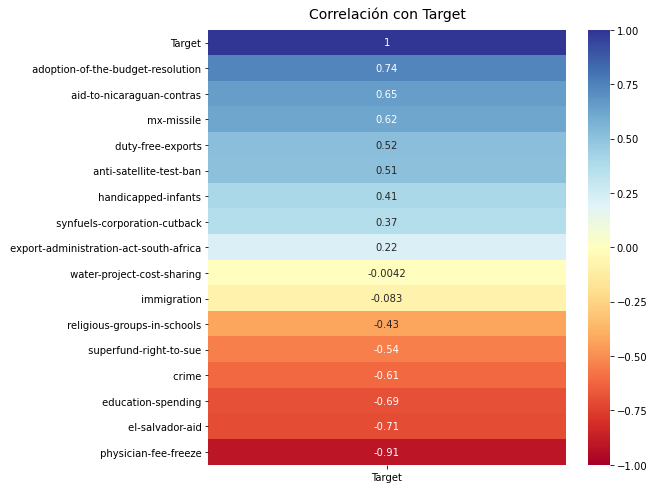

In [3]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(votos_final.corr()[['Target']].sort_values(by='Target',ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='RdYlBu')
heatmap.set_title('Correlación con Target', fontdict={'fontsize':14}, pad=12);

En segundo lugar se analiza la correlación entre todas las variables. Aquí los valores representan oposición ideológica: valores cercanos a -1 indican que raramente uno votaría igual en ambas leyes, mientras que valores cercanos a 1 indican una fuerte correlación ideológica.

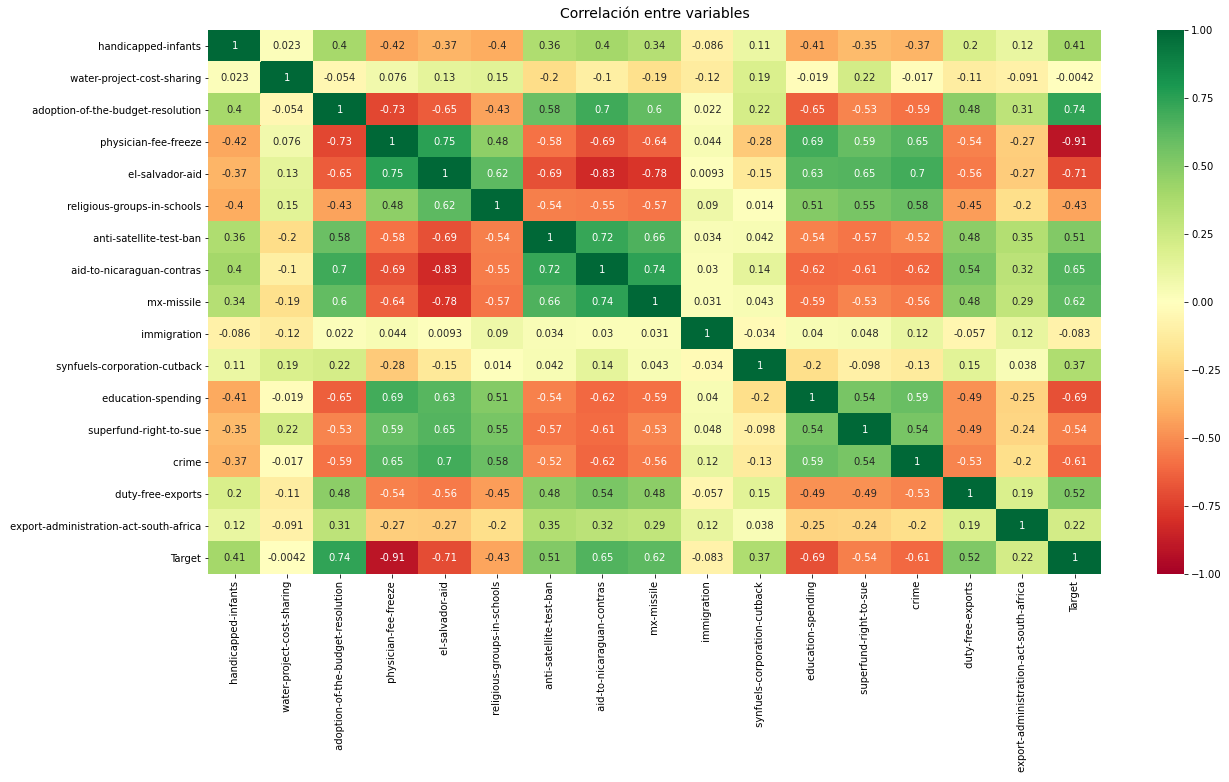

In [4]:
plt.figure(figsize=(20,10))
heatmap_variables = sns.heatmap(votos_final.corr(), annot=True, vmin=-1, vmax=1, cmap='RdYlGn');
heatmap_variables.set_title('Correlación entre variables', fontdict={'fontsize':14}, pad=12);

# 3) Preparación para modelos

Se divide el dataset entre training y test, utilizando la columna Target creada a partir de la columna Class Name  

In [5]:
X = votos_final.iloc[:,1:17]
y = votos_final["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

Se verifica que coincidan las proporciones del target

In [6]:
print("Proporciones del Train:")
print(y_train.value_counts(normalize=True))
print("Proporciones del Test:")
print(y_test.value_counts(normalize=True))

Proporciones del Train:
1    0.615132
0    0.384868
Name: Target, dtype: float64
Proporciones del Test:
1    0.610687
0    0.389313
Name: Target, dtype: float64


Se estandarizan los datos para que la regularización sea correcta

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Se utilizará la métrica del valor mayoritario como base para el rendimiento de los modelos a probar

In [8]:
print("El porcentaje de demócratas es de", (y_test.value_counts(normalize=True).max().round(2)*100))

El porcentaje de demócratas es de 61.0


# 4) Naive Bayes

#### Se ajusta el modelo

In [9]:
nbc = GaussianNB()
nbc.fit(X_train_std, y_train)

GaussianNB()

#### Predicciones

In [10]:
y_preds_nb = nbc.predict(X_test)
y_probs_nb = nbc.predict_proba(X_test)

## Resultados:

#### Métricas

In [11]:
print('Accuracy =', accuracy_score(y_test, y_preds_nb).round(2))
print('Recall =', recall_score(y_test, y_preds_nb).round(2))
print('Precision =', precision_score(y_test, y_preds_nb).round(2))

Accuracy = 0.93
Recall = 0.95
Precision = 0.94


#### Classification Report

In [12]:
print(classification_report(y_test, y_preds_nb))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        51
           1       0.94      0.95      0.94        80

    accuracy                           0.93       131
   macro avg       0.93      0.93      0.93       131
weighted avg       0.93      0.93      0.93       131



#### Matriz de confusión

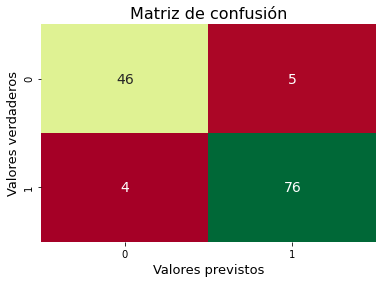

In [13]:
gnb_votos = confusion_matrix(y_test, y_preds_nb)
plt.plot(30)
ax = sns.heatmap(gnb_votos, annot=True, cmap='RdYlGn', cbar=False,
                    annot_kws={"size": 14}, fmt='g')

plt.title('Matriz de confusión', size =16)
plt.xlabel('Valores previstos', size = 13)
plt.ylabel('Valores verdaderos', size=13);

# 5) Regresión Logística

#### Se ajusta el modelo

In [14]:
logisticR = LogisticRegression()
logisticR.fit(X_train_std, y_train)

LogisticRegression()

#### Predicciones

In [15]:
y_pred_lg = logisticR.predict(X_test)

## Resultados:

#### Métricas

In [16]:
print('Accuracy =', accuracy_score(y_test, y_pred_lg).round(2))
print('Recall =', recall_score(y_test, y_pred_lg).round(2))
print('Precision =', precision_score(y_test, y_pred_lg).round(2))

Accuracy = 0.95
Recall = 0.98
Precision = 0.95


#### Classification Report

In [17]:
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        51
           1       0.95      0.97      0.96        80

    accuracy                           0.95       131
   macro avg       0.96      0.95      0.95       131
weighted avg       0.95      0.95      0.95       131



#### Matriz de Confusión 

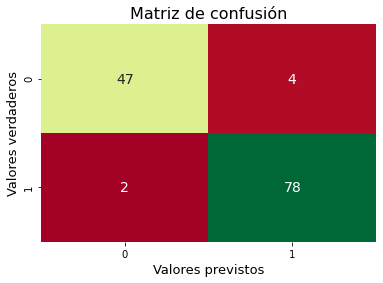

In [18]:
cm_votos = confusion_matrix(y_test, y_pred_lg)
plt.plot(30)
ax = sns.heatmap(cm_votos, annot=True, cmap='RdYlGn', cbar=False,
                    annot_kws={"size": 14}, fmt='g')

plt.title('Matriz de confusión', size =16)
plt.xlabel('Valores previstos', size = 13)
plt.ylabel('Valores verdaderos', size=13);

# 6) Optimización vía Umbral

Se cambia el umbral de decisión para bajar la tasa de falsos positivos y analizar la variación en los resultados

In [19]:
y_probs_umb = logisticR.predict_proba(X_test)
y_probs_umb_data = y_probs_umb[:,1]
y_pred_umb = y_probs_umb_data > 0.7

## Resultados:

#### Métricas

In [20]:
print('Accuracy =', accuracy_score(y_test, y_pred_umb).round(2))
print('Recall =', recall_score(y_test, y_pred_umb).round(2))
print('Precision =', precision_score(y_test, y_pred_umb).round(2))

Accuracy = 0.95
Recall = 0.95
Precision = 0.96


#### Classification Report

In [21]:
print(classification_report(y_test, y_pred_umb))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        51
           1       0.96      0.95      0.96        80

    accuracy                           0.95       131
   macro avg       0.94      0.95      0.94       131
weighted avg       0.95      0.95      0.95       131



#### Matriz de Confusión

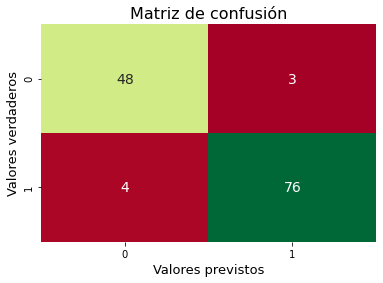

In [22]:
cm_votos = confusion_matrix(y_test, y_pred_umb)
plt.plot(30)
ax = sns.heatmap(cm_votos, annot=True, cmap="RdYlGn", cbar=False,
                    annot_kws={"size": 14}, fmt='g')

plt.title('Matriz de confusión', size =16)
plt.xlabel('Valores previstos', size = 13)
plt.ylabel('Valores verdaderos', size=13);

# 7) Optimización vía Grid Search

Se busca el mejor hiperparámetro. Debido a que la base de datos es muy chica, se puede utilizar Grid Search en vez de Random Search pues el tiempo de ejecución no es un obstáculo y el primero arroja mejores resultados. Se probó también con alteraciones de solver pero resultaba en ineficacia de convergencia u otros warnings.

### Accuracy

In [23]:
grid_search_logistic_accuracy = GridSearchCV(LogisticRegression(),  {'C': [1, 10, 100, 1000]}, cv=5, scoring='accuracy')
grid_search_logistic_accuracy.fit(X_train_std, y_train)

print(grid_search_logistic_accuracy.best_score_.round(2))
print(grid_search_logistic_accuracy.best_params_)
print(grid_search_logistic_accuracy.best_estimator_)

0.97
{'C': 1}
LogisticRegression(C=1)


### Recall

In [24]:
grid_search_logistic_recall = GridSearchCV(LogisticRegression(),  {'C': [1, 10, 100, 1000]}, cv=5, scoring='recall')
grid_search_logistic_recall.fit(X_train_std, y_train)

print(grid_search_logistic_recall.best_score_.round(2))
print(grid_search_logistic_recall.best_params_)
print(grid_search_logistic_recall.best_estimator_)

0.97
{'C': 1}
LogisticRegression(C=1)


### Precision

In [25]:
grid_search_logistic_precision = GridSearchCV(LogisticRegression(),  {'C': [1, 10, 100, 1000]}, cv=5, scoring='precision')
grid_search_logistic_precision.fit(X_train_std, y_train)

print(grid_search_logistic_precision.best_score_.round(2))
print(grid_search_logistic_precision.best_params_)
print(grid_search_logistic_precision.best_estimator_)

0.98
{'C': 1}
LogisticRegression(C=1)


### Matriz de Confusión

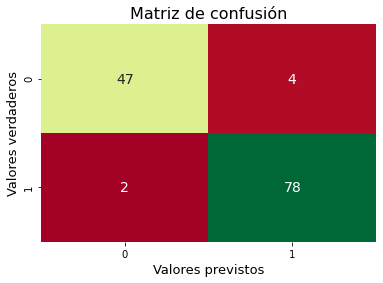

In [26]:
y_pred_gs = grid_search_logistic_accuracy.predict(X_test) #Se utiliza el de accuracy, pero con los 3 el resultado de la matriz es el mismo
cm_votos = confusion_matrix(y_test, y_pred_gs)
plt.plot(30)
ax = sns.heatmap(cm_votos, annot=True, cmap="RdYlGn", cbar=False,
                    annot_kws={"size": 14}, fmt='g')

plt.title('Matriz de confusión', size =16)
plt.xlabel('Valores previstos', size = 13)
plt.ylabel('Valores verdaderos', size=13);

# 8) Evaluación de modelos

### A) Análisis de la curva ROC

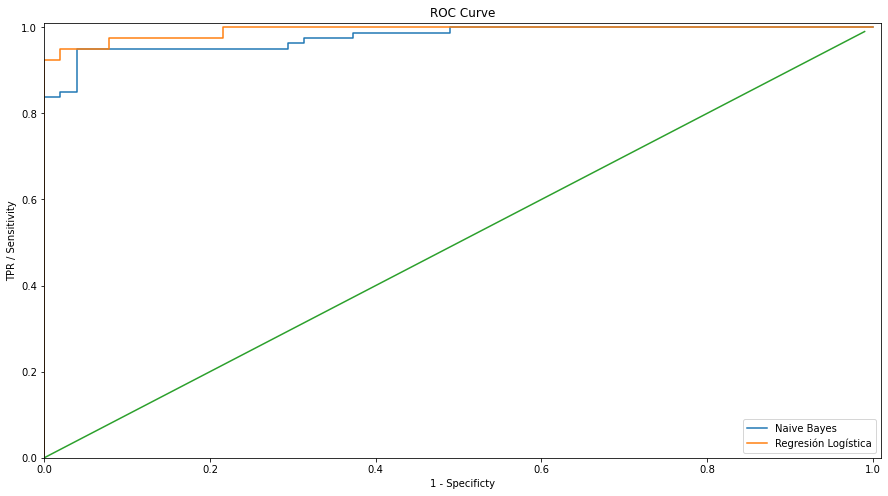

In [27]:
fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_probs_nb[:,1])
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_probs_umb[:,1])

plt.figure(figsize=(15, 8))
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['Naive Bayes','Regresión Logística'])
plt.show()

Se procede a calcular el AUC para cada modelo

In [28]:
print('AUC con Naive Bayes:', auc(fpr_nb, tpr_nb))
print('AUC con Regresión Logística:', auc(fpr_log, tpr_log))

AUC con Naive Bayes: 0.9774509803921568
AUC con Regresión Logística: 0.9921568627450981


### B) Comparación de las métricas de los diferente modelos

Se graficará el rendimiento de los 5 modelos usados (Valor mayoritario, Naive Bayes, Regresión logística, Regresión logística con umbral y Regresión logística con Grid Search) según las 3 métricas: accuracy, precision y recall

In [29]:
Accuracy_valor_mayoritario = y_test.value_counts(normalize=True).max().round(2)
Accuracy_NB =  accuracy_score(y_test, y_preds_nb).round(2)
Accuracy_RL = accuracy_score(y_test, y_pred_lg).round(2)
Accuracy_RL_umbral = accuracy_score(y_test, y_pred_umb).round(2)
Accuracy_GS = grid_search_logistic_accuracy.best_score_.round(2)

Accuracy_plot = Accuracy_valor_mayoritario, Accuracy_NB, Accuracy_RL, Accuracy_RL_umbral, Accuracy_GS

In [30]:
Recall_valor_mayoritario = (votos_final['Target'] == 1).sum()/(votos_final['Target'] == 1).sum() + 0 # Se suma 0 pues no hay falsos negativos al calcular según la clase mayoritaria
Recall_NB = recall_score(y_test, y_preds_nb).round(2)
Recall_RL = recall_score(y_test, y_pred_lg).round(2)
Recall_RL_umbral = recall_score(y_test, y_pred_umb).round(2)
Recall_GS = grid_search_logistic_recall.best_score_.round(2)

Recall_plot = Recall_valor_mayoritario, Recall_NB, Recall_RL, Recall_RL_umbral, Recall_GS

In [31]:
Precision_valor_mayoritario = (votos_final['Target'] == 1).sum()/votos_final.Target.count()
Precision_NB = precision_score(y_test, y_preds_nb).round(2)
Precision_RL = precision_score(y_test, y_pred_lg).round(2)
Precision_RL_umbral= precision_score(y_test, y_pred_umb).round(2)
Precision_GS = grid_search_logistic_precision.best_score_.round(2)

Precision_plot = Precision_valor_mayoritario, Precision_NB, Precision_RL, Precision_RL_umbral, Precision_GS

In [32]:
F1_valor_mayoritario = 2*((Precision_valor_mayoritario * Recall_valor_mayoritario) / (Precision_valor_mayoritario + Recall_valor_mayoritario)).round(2)
F1_NB = f1_score(y_test,y_preds_nb).round(2)
F1_RL = f1_score(y_test, y_pred_lg).round(2)
F1_RL_umbral= f1_score(y_test, y_pred_umb).round(2)
F1_GS = 2*((Precision_GS*Recall_GS) / (Precision_GS+Recall_GS)).round(2)

F1_plot = F1_valor_mayoritario, F1_NB, F1_RL, F1_RL_umbral, F1_GS

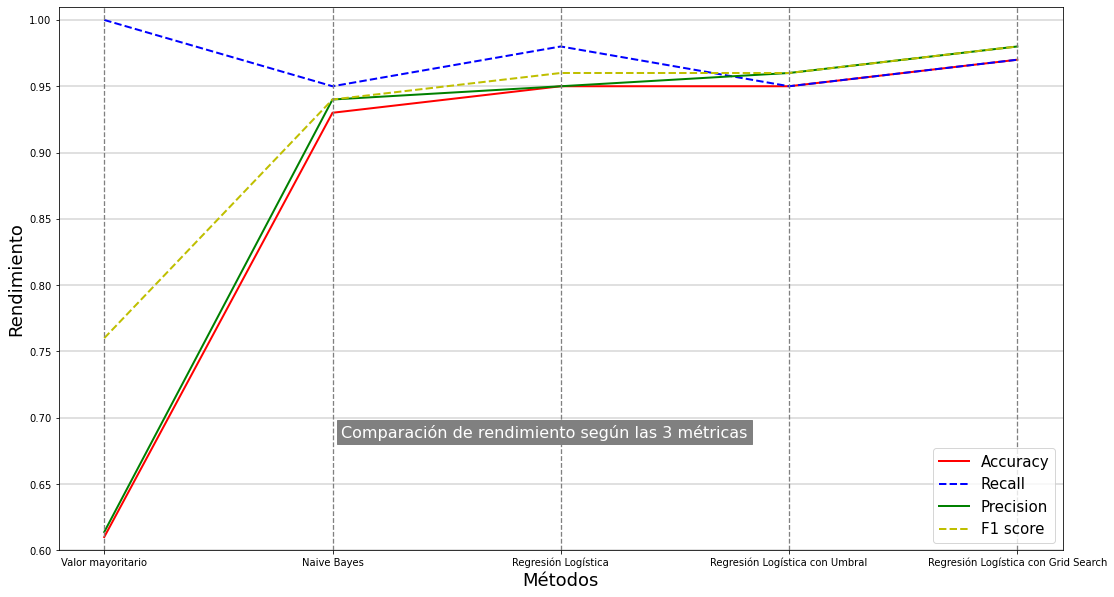

In [33]:
plt.figure(figsize=(18, 10)).suptitle('Comparación de rendimiento según las 3 métricas', y=0.3, fontsize = 16, color='white', backgroundcolor='gray')
plt.plot(Accuracy_plot, color='red', linewidth=2, label = "Accuracy")
plt.plot(Recall_plot, color='blue', linewidth=2, linestyle = "--", label = "Recall")
plt.plot(Precision_plot, color='green', linewidth=2, label = "Precision")
plt.plot(F1_plot, color='y', linewidth=2, linestyle = "--", label = "F1 score")
plt.xlabel('Métodos', fontsize=18)
plt.ylabel('Rendimiento', fontsize=18)
plt.legend(fontsize = 15)


axes= plt.gca()
ymin= .60
ymax= 1.01
axes.set_ylim([ymin, ymax])

plt.axvline(x='Valor mayoritario', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Naive Bayes',color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Regresión Logística', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Regresión Logística con Umbral' , color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Regresión Logística con Grid Search', color="grey", linestyle="--", lw=1.3)
plt.grid(which='major', axis='y', color='black', lw=0.4, alpha=0.6)
plt.show()